# Описание проекта

Стартап продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.  
Изучим воронку продаж. Узнаем, как пользователи доходят до покупки.   
Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? И на каких именно?  
Исследуем результаты A/A/B-эксперимента. Дизайнеры хотят поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно.   
Договорились принять решение по результатам A/A/B-теста.   Пользователей разбили на 3 группы:  
2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.   Выясним, какой шрифт лучше.  

# Описание данных

Каждая запись в логе — это действие пользователя, или событие.
-	EventName — название события;
-	DeviceIDHash — уникальный идентификатор пользователя;
-	EventTimestamp — время события;
-	ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


# Загрузка данных

In [44]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats as st
import math as mth

In [45]:
# считываем файл с данными
try:
    df = pd.read_csv('logs_exp.csv', sep='\\t')
except FileNotFoundError:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\\t')

In [46]:
# общая информация по таблице df_orders
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
"EventName        244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId"            244126 non-null object
dtypes: int64(2), object(2)
memory usage: 7.5+ MB


,"""EventName",DeviceIDHash,EventTimestamp,"ExpId"""
0,"""MainScreenAppear",4575588528974610257,1564029816,"246"""
1,"""MainScreenAppear",7416695313311560658,1564053102,"246"""
2,"""PaymentScreenSuccessful",3518123091307005509,1564054127,"248"""
3,"""CartScreenAppear",3518123091307005509,1564054127,"248"""
4,"""PaymentScreenSuccessful",6217807653094995999,1564055322,"248"""


# Подготовка данных

## Замена названия столбцов

In [4]:
# замена столбцов на удобные в стиле snake case
df = df.rename(columns={'"EventName':'event', 'DeviceIDHash':'device_id', 
                          'EventTimestamp':'event_time', 'ExpId"':'exp_id'})
df.head()

,event,device_id,event_time,exp_id
0,"""MainScreenAppear",4575588528974610257,1564029816,"246"""
1,"""MainScreenAppear",7416695313311560658,1564053102,"246"""
2,"""PaymentScreenSuccessful",3518123091307005509,1564054127,"248"""
3,"""CartScreenAppear",3518123091307005509,1564054127,"248"""
4,"""PaymentScreenSuccessful",6217807653094995999,1564055322,"248"""


## 	Проверим пропуски и типы данных.

In [ ]:
# проверим дубликаты
print(f'Всего {df.duplicated().sum()} дубликатов в таблице')

In [6]:
# посмотрим, что за дубликаты
df.loc[df.duplicated(keep=False)].sort_values(by=['device_id','event']).head(10)

,event,device_id,event_time,exp_id
130557,"""MainScreenAppear",33176906322804559,1564933075,"248"""
130558,"""MainScreenAppear",33176906322804559,1564933075,"248"""
130994,"""OffersScreenAppear",33176906322804559,1564933763,"248"""
130995,"""OffersScreenAppear",33176906322804559,1564933763,"248"""
104106,"""CartScreenAppear",34565258828294726,1564857221,"248"""
104108,"""CartScreenAppear",34565258828294726,1564857221,"248"""
159301,"""PaymentScreenSuccessful",54903596035630984,1565011672,"248"""
159302,"""PaymentScreenSuccessful",54903596035630984,1565011672,"248"""
176812,"""PaymentScreenSuccessful",77364241990273403,1565044732,"246"""
176813,"""PaymentScreenSuccessful",77364241990273403,1565044732,"246"""


Дубликаты образовались при неверной выгрузке в файл или ошибки при записях логов.  
Явно одни и теже события невозможны одновременно и дубликаты следует удалить.

In [7]:
# удаляем дубликаты, кроме первого вхождения и проверяем их отсутствие
# при удалении дубликатов переиндексируем датасет с удалением старых индексов
df = df.drop_duplicates().reset_index(drop=True)
# проверяем после удаления количество дубликатов
print(f'Всего {df.duplicated().sum()} дубликата(ов) в таблице')

Всего 0 дубликата(ов) в таблице


Приведём колонку с датой и временем события в типу дата.

In [8]:
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')

In [9]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
event         243713 non-null object
device_id     243713 non-null int64
event_time    243713 non-null datetime64[ns]
exp_id        243713 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 7.4+ MB


,event,device_id,event_time,exp_id
0,"""MainScreenAppear",4575588528974610257,2019-07-25 04:43:36,"246"""
1,"""MainScreenAppear",7416695313311560658,2019-07-25 11:11:42,"246"""
2,"""PaymentScreenSuccessful",3518123091307005509,2019-07-25 11:28:47,"248"""
3,"""CartScreenAppear",3518123091307005509,2019-07-25 11:28:47,"248"""
4,"""PaymentScreenSuccessful",6217807653094995999,2019-07-25 11:48:42,"248"""


In [10]:
print(f'Всего пропусков в таблице \n{df.isna().sum()}')

Всего пропусков в таблице 
event         0
device_id     0
event_time    0
exp_id        0
dtype: int64


## 	Добавим столбец даты

In [11]:
# выделяем столбец с датой
df['event_date'] = df['event_time'].dt.date
df.head()

,event,device_id,event_time,exp_id,event_date
0,"""MainScreenAppear",4575588528974610257,2019-07-25 04:43:36,"246""",2019-07-25
1,"""MainScreenAppear",7416695313311560658,2019-07-25 11:11:42,"246""",2019-07-25
2,"""PaymentScreenSuccessful",3518123091307005509,2019-07-25 11:28:47,"248""",2019-07-25
3,"""CartScreenAppear",3518123091307005509,2019-07-25 11:28:47,"248""",2019-07-25
4,"""PaymentScreenSuccessful",6217807653094995999,2019-07-25 11:48:42,"248""",2019-07-25


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
event         243713 non-null object
device_id     243713 non-null int64
event_time    243713 non-null datetime64[ns]
exp_id        243713 non-null object
event_date    243713 non-null object
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 9.3+ MB


# Изучим и проверим данные

## 	Сколько всего событий в логе

In [13]:
df.event.value_counts()

"MainScreenAppear           119101
"OffersScreenAppear          46808
"CartScreenAppear            42668
"PaymentScreenSuccessful     34118
"Tutorial                     1018
Name: event, dtype: int64

Всего 5 событий в логе:
- `"MainScreenAppear` (пользователь на главном экране)
- `"OffersScreenAppear` (пользователь увидел предложение)
- `"CartScreenAppear` (добавление товара в корзину)
- `"PaymentScreenSuccessful` (успешная оплата)
- `"Tutorial` (особняком стоит просмотр руководства пользователя)

## 	Сколько всего пользователей в логе

In [14]:
print(f'Всего {df.device_id.nunique()} уникальных пользователей в логе')

Всего 7551 уникальных пользователей в логе


## Сколько в среднем событий приходится на пользователя

In [15]:
device_id_event_mean = df.groupby('device_id').agg({'event':'count'}).event.mean().round().astype('int8')
print(f'Всего {device_id_event_mean} события в среднем на пользователя')

Всего 32 события в среднем на пользователя


In [16]:
df.pivot_table(index='device_id', columns='event', values='event_time', aggfunc='count').fillna(0).describe().round(2)

event,"""CartScreenAppear","""MainScreenAppear","""OffersScreenAppear","""PaymentScreenSuccessful","""Tutorial"
count,7551.00,7551.00,7551.00,7551.00,7551.00
mean,5.65,15.77,6.20,4.52,0.13
std,27.34,16.26,13.46,25.61,0.54
min,0.00,0.00,0.00,0.00,0.00
25%,0.00,6.00,0.00,0.00,0.00
50%,0.00,11.00,2.00,0.00,0.00
75%,5.00,21.00,8.00,4.00,0.00
max,1100.00,206.00,509.00,1085.00,27.00


Посмотрели данные по по пользователям по количеству логов по каждому событию.

##  Данные за какой период. Найдём максимальную и минимальную дату. Построем гистограмму по дате и времени. 

In [17]:
print(f'Минимальная дата лога {df.event_time.min()}\nМаксимальная дата лога {df.event_time.max()}')

Минимальная дата лога 2019-07-25 04:43:36
Максимальная дата лога 2019-08-07 21:15:17


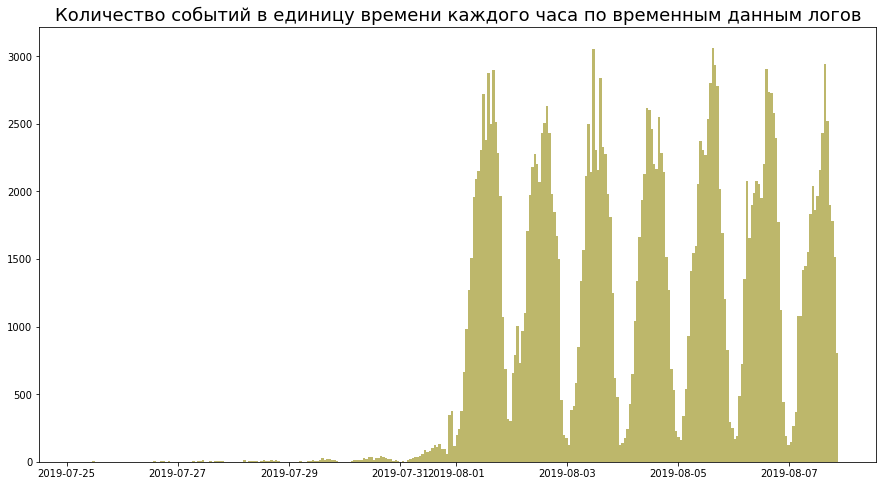

In [18]:
fig, ax = plt.subplots(figsize=(15,8))

# строим гистрограмму по количеству событий с разбивкой каждого часа в период данных логов
# bins считаем как разность начала и конца данных логов умноженных на количество часов в сутки 
ax.hist(df.event_time, bins=(df.event_date.max() - df.event_date.min()).days * 24, color='#BDB76B')
plt.title('Количество событий в единицу времени каждого часа по временным данным логов', fontsize=18)
plt.show()

По гистограмме видно, что в первую неделю есть крайне малое количество событий.  
Основные события начинаются с 01 августа по 07 августа со спадами каждый день вероятно в ночные часы.

## Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. 

Очистим данные за первую неделю, так как события, как выше на графике, преобретают устойчивый характер событий логов начиная со второй недели.

In [19]:
# оставляем данные только за вторую неделю с 01 по 08 августа
df = df.query('event_date > Timestamp("2019-07-31")')

In [20]:
print(f'\nВсего осталось {df.device_id.nunique()} уникальных пользователей')


Всего осталось 7534 уникальных пользователей


После очистки данных за первую неделю мы лишились 17 пользователей в данных.

Проверяю количество пользователей, у которых первое событие не является открытием стартовой страницы. Буду руководствоваться соображениями, что новые пользователи должны первым событием иметь **"MainScreenAppear**, а дальше уже могут быть остальные логи.  Если у `device_id` первым логом идёт иное событие, то тогда стоит предполагать, что пользователь не новый.  

In [21]:
# создаю таблицу с группированными данными по пользователю и событию с самой ранней датой события
# хочу найти id и все первые события по пользователю, чтобы в дальнейшем выделить первое событие по пользователю
min_date_event = ( df.sort_values(by=['event', 'event_time']).groupby(['device_id','event']).
                  agg({'event_time':'min'}).
                  reset_index().
                  sort_values(by=['device_id', 'event_time'])
)

# выбираю первое событие совершенное пользователем 
min_date_event = min_date_event.groupby('device_id').agg({'event_time':'min','event':'first'})

# получаю все device_id, логам которых соответствием первым событием "MainScreenAppear, которое я 
# определил для новых пользователей
device_id_new = min_date_event.query('event == "\\"MainScreenAppear"').reset_index().device_id


In [22]:
df.info()
print(f'\nВсего {df.device_id.nunique() - device_id_new.count()} уникальных пользователей,\
которые могут быть старыми пользователями')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 5 columns):
event         240887 non-null object
device_id     240887 non-null int64
event_time    240887 non-null datetime64[ns]
exp_id        240887 non-null object
event_date    240887 non-null object
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 11.0+ MB

Всего 1228 уникальных пользователей,которые могут быть старыми пользователями


## 	Проверим, что есть пользователи из всех трёх экспериментальных групп.

In [23]:
# функция строит барплот
def df_barplot(df, column_x, column_y, **kwargs):
    plt.figure(figsize=kwargs.get('figsize', (15, 6)))
# устанавливаем стиль
    sns.set(style="white")
    sns.barplot(x=column_x, y=column_y, data=df)
    plt.title(label=kwargs.get('title'), fontsize=kwargs.get('fontsize_title', 20))
    plt.xlabel(xlabel=kwargs.get('x_label',''), fontsize=kwargs.get('fontsize_xlabel', 16))
    plt.ylabel(ylabel=kwargs.get('y_label',''), fontsize=kwargs.get('fontsize_ylabel', 16))    
# убираем оси, кроме нижней
    sns.despine(left=True)
    plt.show()    

In [24]:
# группируем device_id по экспериментальным группам
device_id_group_id = df.groupby('exp_id').agg({'device_id':'nunique'}).reset_index()

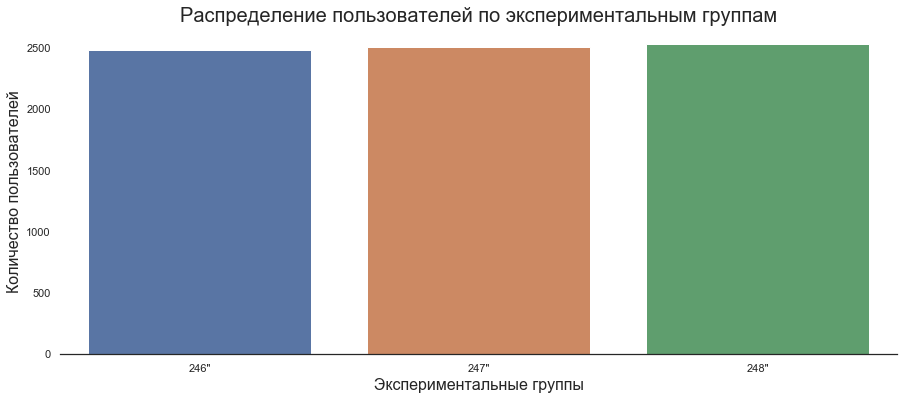

,exp_id,device_id
0,"246""",2484
1,"247""",2513
2,"248""",2537


In [25]:
df_barplot(device_id_group_id, 'exp_id', 'device_id', title='Распределение пользователей по экспериментальным группам',
          x_label='Экспериментальные группы', y_label='Количество пользователей')
device_id_group_id

Экспериментальные группы 246" и 247" и 248" имеют примерно равное количество пользователей с разбежкой в пару десятков.

# Изучим воронку событий

## 	Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

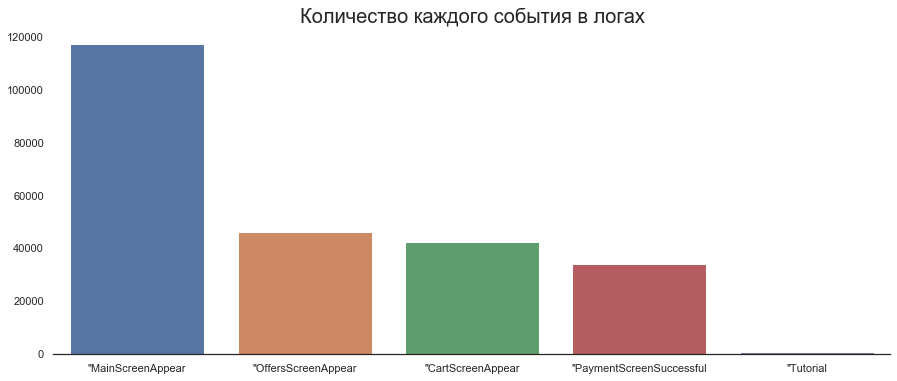

,event,device_id
1,"""MainScreenAppear",117328
2,"""OffersScreenAppear",46333
0,"""CartScreenAppear",42303
3,"""PaymentScreenSuccessful",33918
4,"""Tutorial",1005


In [26]:
# группирую события в логах и сортирую по частоте
event_frecuency = df.groupby('event').agg({'device_id':'count'}).reset_index().sort_values(by='device_id', ascending=False)

# барплот по событиям
df_barplot(event_frecuency, 'event', 'device_id', title='Количество каждого события в логах')

event_frecuency

## 	Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

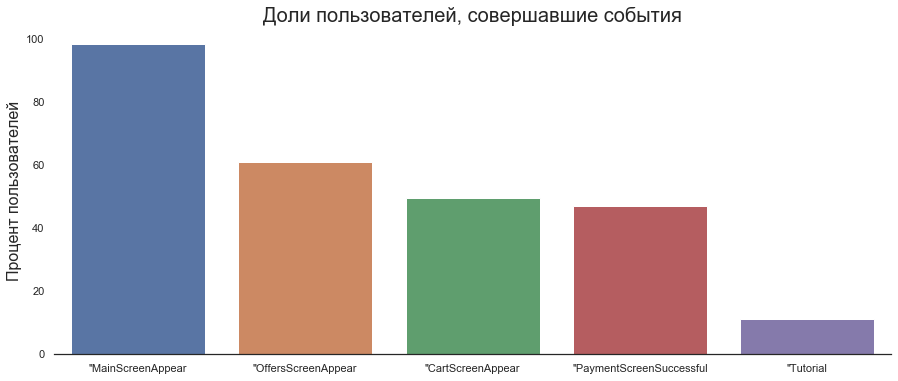

,index,event,device_id,device_id_share
0,1,total,7534,100.00
1,2,"""MainScreenAppear",7419,98.47
2,3,"""OffersScreenAppear",4593,60.96
3,4,"""CartScreenAppear",3734,49.56
4,5,"""PaymentScreenSuccessful",3539,46.97
5,6,"""Tutorial",840,11.15


In [27]:
# группируем события по уникальным device_id и сортируем от большего к меньшему
device_id_nunique_e = ( df.groupby('event').agg({'device_id':'nunique'}).
                           sort_values(by='device_id', ascending=False).
                           reset_index()
)
# создаем датафрейм с событие всего и уникальными пользователями, чтобы сконкатенировать потом с device_id_nunique_e
# датафрейм именно для этого index=[0,1], чтобы соединить, а потом лишнюю строку удалим
total_id = pd.DataFrame(data={'event':'total', 'device_id': df.device_id.nunique()}, index=[0,1])

# соединяем два датафрейма и удаляем повторяющую строку total:всего пользователей
device_id_nunique_event = pd.concat([total_id, device_id_nunique_e], ignore_index=True)
device_id_nunique_event = device_id_nunique_event.loc[1:].reset_index()

# выделяем столбец по доли пользователей, совершавших каждое из событий
device_id_nunique_event['device_id_share'] = ( (device_id_nunique_event['device_id'] /  
                                            device_id_nunique_event['device_id'][0] * 100).round(2)
)

df_barplot(device_id_nunique_event.query('event != "total"'), 'event', 'device_id_share', 
           title='Доли пользователей, совершавшие события',
           y_label='Процент пользователей')

device_id_nunique_event

## 	Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку и нужно ли учитывать все при расчёте воронки.

Сначала пользователь оказывается на главном экране - это событие `"MainScreenAppear`  
далее пользователь видит предложение товаров или ассортимент - это событие `"OffersScreenAppear`  
после событие добавление товаров в корзину - это событие `"CartScreenAppear`
конечный итог успешная оплата товаров - это событие `"PaymentScreenSuccessful`  
Событие `"Tutorial` - руководство или инструкция по совершению покупки. Данное событие не связано с воронкой события по покупке товаров. Данное событие может увеличивать долю пользователей, которые доходят до покупки, так и уменьшать долю, если руководство написано очень запутано, но не должно учитываться в воронке продаж. 

## 	По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [28]:
# удалим последнюю строку с событием "Tutorial, как нерелевантное к нашей воронке событий
device_id_nunique_event = device_id_nunique_event.iloc[:5]

# до целого числа округляем столбец с процентом переходящих пользователей по событиям
device_id_nunique_event.device_id_share = round(device_id_nunique_event.device_id_share, 0)

# создаем столбец с предыдущими значениями по колонке devide_id, первое значение, которое должно стать Nan
# заполняем fill_value значением первого события
device_id_nunique_event['device_id_shift'] = ( device_id_nunique_event['device_id'].
                                             shift(fill_value=device_id_nunique_event.device_id[0])
)

device_id_nunique_event['device_id_percent%'] = ( (device_id_nunique_event['device_id'] / 
                                                 device_id_nunique_event['device_id_shift'] * 100).round()
)

device_id_nunique_event = device_id_nunique_event.loc[1:]

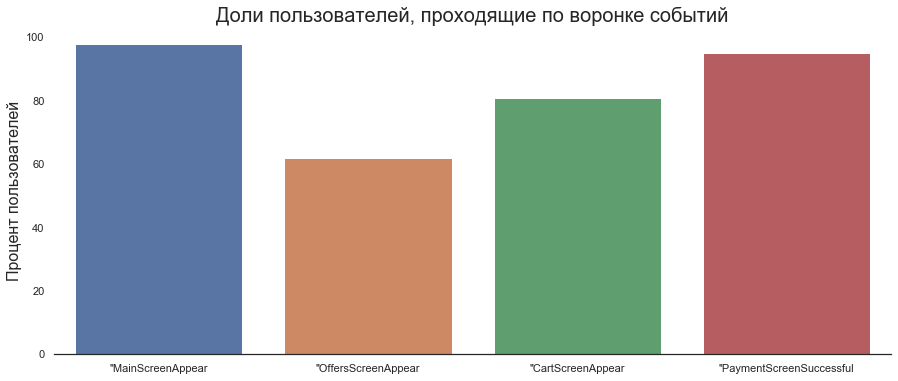

,index,event,device_id,device_id_share,device_id_shift,device_id_percent%
1,2,"""MainScreenAppear",7419,98.0,7534,98.0
2,3,"""OffersScreenAppear",4593,61.0,7419,62.0
3,4,"""CartScreenAppear",3734,50.0,4593,81.0
4,5,"""PaymentScreenSuccessful",3539,47.0,3734,95.0


In [29]:
df_barplot(device_id_nunique_event, 'event', 'device_id_percent%', title='Доли пользователей, проходящие по воронке событий',
          y_label='Процент пользователей')

device_id_nunique_event

## 	На каком шаге теряете больше всего пользователей. 	Доля пользователей доходит от первого события до оплаты.

Можем видеть, что больше всего теряется пользователей, около 38% на переходе с первого на второе событие, 81% доходит до корзины после получения предложения и 95% оплачивают товары после корзины.  
Всего 47% пользователей доходит до оплаты товара от изначального количества.

# Изучим результаты эксперимента

## 	Сколько пользователей в каждой экспериментальной группе.

Ранее мы уже определили количество пользователей в каждой из групп. Они примерно равны.

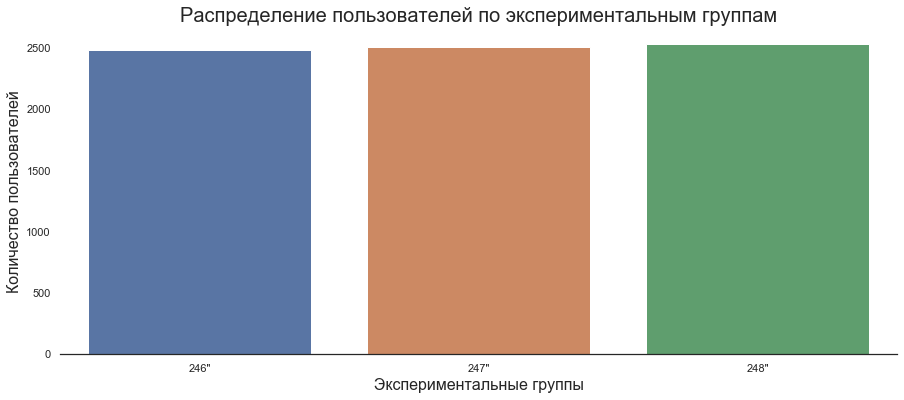

,exp_id,device_id
0,"246""",2484
1,"247""",2513
2,"248""",2537


In [30]:
df_barplot(device_id_group_id, 'exp_id', 'device_id', title='Распределение пользователей по экспериментальным группам',
          x_label='Экспериментальные группы', y_label='Количество пользователей')
device_id_group_id

## 	Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Проверим корректность выполнения всех механизмов и расчётов для двух груп - 246 и 247:

- Проверим, что количество пользователей, попавших в различные группы, не отличается или имеет очень небольшое отличие.

In [31]:
difference_246_247 = (abs(device_id_group_id.query('exp_id == "247\\""')['device_id'].sum() - 
device_id_group_id.query('exp_id == "246\\""')['device_id'].sum()) / (
    device_id_group_id.query('exp_id == "247\\""')['device_id'].sum() + 
    device_id_group_id.query('exp_id == "246\\""')['device_id'].sum())).round(4)
print(f'Разность количества пользователей {difference_246_247:.2%} между двумя группами А/А теста')

Разность количества пользователей 0.58% между двумя группами А/А теста


- Данные во всех группах отправляются в системы аналитики одинаково - наши тестировщики за этим проследили, будем исходить из этого.  
- Каждый посетитель, попавший в одну из групп теста, остаётся в этой группе до конца теста.

In [32]:
# проверяем, чтобы все пользователи попадали только в одну экспериментальную группу
device_id_different_exp_id = (df.groupby('device_id').agg({'exp_id':'nunique'}).reset_index().
        sort_values(by='exp_id', ascending=False).query('exp_id > 1')['exp_id'].count())
print(f'Количество пользователей - {device_id_different_exp_id}, попавших в несколько экспериментальных групп')

Количество пользователей - 0, попавших в несколько экспериментальных групп


- Различие конверсии перехода пользователей по группам не более 1% и не имеет статистической значимости

In [33]:
# группируем события по уникальным device_id и сортируем от большего к меньшему
device_id_exp_id = ( df.query('event != "\\"Tutorial"').groupby(['event','exp_id']).agg({'device_id':'nunique'}).
                           sort_values(by='device_id', ascending=False).
                           reset_index()
                   )
device_id_exp_id

,event,exp_id,device_id
0,"""MainScreenAppear","248""",2493
1,"""MainScreenAppear","247""",2476
2,"""MainScreenAppear","246""",2450
3,"""OffersScreenAppear","246""",1542
4,"""OffersScreenAppear","248""",1531
5,"""OffersScreenAppear","247""",1520
6,"""CartScreenAppear","246""",1266
7,"""CartScreenAppear","247""",1238
8,"""CartScreenAppear","248""",1230
9,"""PaymentScreenSuccessful","246""",1200


In [34]:
# создадим таблицу с общим количеством пользователей по группам
total_exp_id = df.groupby('exp_id').agg({'device_id':'nunique'}).reset_index()
total_exp_id['event'] ='total'
total_exp_id

,exp_id,device_id,event
0,"246""",2484,total
1,"247""",2513,total
2,"248""",2537,total


In [35]:
# получаем общую таблицу по пользователям и событиям по всем группам
device_id_exp_id_total = pd.concat([total_exp_id, device_id_exp_id], ignore_index=True)
device_id_exp_id_total

,device_id,event,exp_id
0,2484,total,"246"""
1,2513,total,"247"""
2,2537,total,"248"""
3,2493,"""MainScreenAppear","248"""
4,2476,"""MainScreenAppear","247"""
5,2450,"""MainScreenAppear","246"""
6,1542,"""OffersScreenAppear","246"""
7,1531,"""OffersScreenAppear","248"""
8,1520,"""OffersScreenAppear","247"""
9,1266,"""CartScreenAppear","246"""


In [36]:
# z-тест для пропорций
# на вход подаем сгруппированную таблицу по событиям event и экспериментальным группам exp_id, в которой 
# считаются уникальные пользователи device_id : nunique  

def z_test(df, exp_1, exp_2, event, event_early, alpha = .01):
    # массив успешных переходов или количество уникальных device_id в логах событий по двум экспериментам
    successes =  np.array([ df.loc[(df['exp_id'] == exp_1) & (df['event'] == event), 'device_id'].sum(),
                           df.loc[(df['exp_id'] == exp_2) & (df['event'] == event), 'device_id'].sum()])
 
    # массив общего количества device_id или количество уникальных device_id в логах раннего события события
    # по двум экспериментам
    trials = np.array([ df.loc[(df['exp_id'] == exp_1) & (df['event'] == event_early), 'device_id'].sum(),
                           df.loc[(df['exp_id'] == exp_2) & (df['event'] == event_early), 'device_id'].sum()])
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print(f'Отвергаем нулевую гипотезу: между долями экспериментальных групп {exp_1}\
 и {exp_2} между событиями {event} и {event_early} есть значимая разница\n')
    else:
        print(
        f'Не получилось отвергнуть нулевую гипотезу.\nНет оснований считать доли {exp_1}\
 и {exp_2} между событиями {event} и {event_early} разными\n'
        )

In [37]:
# список event по воронке событий
list_event = device_id_exp_id_total.event.unique().tolist()
list_event

['total',
 '"MainScreenAppear',
 '"OffersScreenAppear',
 '"CartScreenAppear',
 '"PaymentScreenSuccessful']

In [ ]:
# функция, проверяет по списку z_test для пропорций для двух групп
# проверяем сначала каждое событие к предыдущему, а потом каждое событие к первому

def z_event_all(exp_1, exp_2, df = device_id_exp_id_total, run_one=True, run_two=True):
# тест последующих событий к предыдущим
# run_one=True по умолчанию, чтобы считала статистическую значимость по воронке с к предыдущему    
    if run_one:
        for event in list_event:
            if event == list_event[0]:
                event_early = event
                continue
            z_test(df, exp_1, exp_2, event, event_early)
            event_early = event
# тест последующих событий к общему количеству
# run_two=True по умолчанию, чтобы считала статистическую значимость по воронке с общим количеством
    if run_two:
        for event in list_event:
            if event in (list_event[0], list_event[1]):
                continue
            z_test(df, exp_1, exp_2, event, list_event[0])

In [ ]:
z_event_all('246"', '247"')

## Можно ли сказать, что разбиение на группы работает корректно?

Да, у нас происходит корректное разбиение на группы.   
Мы проверили корректность всех механизмов и расчётов для двух групп А/А-эксперимента. Проверили и выяснили, что статистические критерии разницу между выборками 246 и 247 не находят.

## Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Сделаем выводы из эксперимента.

In [40]:
# сравниваем группы 246" и 247"
z_event_all('246"', '248"')

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 246" и 248" между событиями "MainScreenAppear и total разными

p-значение:  0.2684281587249231
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 246" и 248" между событиями "OffersScreenAppear и "MainScreenAppear разными

p-значение:  0.2112170818054686
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 246" и 248" между событиями "CartScreenAppear и "OffersScreenAppear разными

p-значение:  0.14295341270419004
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 246" и 248" между событиями "PaymentScreenSuccessful и "CartScreenAppear разными

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 246" и 248" между событиями "OffersScreenAppear и total разными

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 246" и 248" между соб

In [41]:
# сравниваем группы 247" и 248"
z_event_all('247"', '248"')

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 247" и 248" между событиями "MainScreenAppear и total разными

p-значение:  0.9869365252844515
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 247" и 248" между событиями "OffersScreenAppear и "MainScreenAppear разными

p-значение:  0.4364903513062255
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 247" и 248" между событиями "CartScreenAppear и "OffersScreenAppear разными

p-значение:  0.005677465395736325
Отвергаем нулевую гипотезу: между долями экспериментальных групп 247" и 248" между событиями "PaymentScreenSuccessful и "CartScreenAppear есть значимая разница

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 247" и 248" между событиями "OffersScreenAppear и total разными

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 247" и 248" м

In [42]:
# cоединим два контрольных эксперимента количетво пользователей
exp_1_2 = ( device_id_exp_id_total.query('exp_id in ("246\\"", "247\\"")').
    groupby('event').
    agg({'device_id':'sum', 'exp_id':'max'}).reset_index()    
)
exp_1_2['exp_id'] = '246"_247"'
exp_1_2
# добавим в основной сгруппированный фрейм суммированные данные
device_id_exp_id_total_246_247_concat = pd.concat([device_id_exp_id_total, exp_1_2], ignore_index=True)
device_id_exp_id_total_246_247_concat

,device_id,event,exp_id
0,2484,total,"246"""
1,2513,total,"247"""
2,2537,total,"248"""
3,2493,"""MainScreenAppear","248"""
4,2476,"""MainScreenAppear","247"""
5,2450,"""MainScreenAppear","246"""
6,1542,"""OffersScreenAppear","246"""
7,1531,"""OffersScreenAppear","248"""
8,1520,"""OffersScreenAppear","247"""
9,1266,"""CartScreenAppear","246"""


In [43]:
# сравниваем группы 246"-247" и 248"
z_event_all('246"_247"', '248"', device_id_exp_id_total_246_247_concat)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 246"_247" и 248" между событиями "MainScreenAppear и total разными

p-значение:  0.5308589432077624
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 246"_247" и 248" между событиями "OffersScreenAppear и "MainScreenAppear разными

p-значение:  0.23905954279947372
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 246"_247" и 248" между событиями "CartScreenAppear и "OffersScreenAppear разными

p-значение:  0.017114434319547067
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 246"_247" и 248" между событиями "PaymentScreenSuccessful и "CartScreenAppear разными

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считать доли 246"_247" и 248" между событиями "OffersScreenAppear и total разными

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу.
Нет оснований считат

**По результатам эксперимента можно сделать вывод, что эксперимент прошёл успешно, изменение шрифта не повлияло на конверсию пользователей по воронке событий.**

## Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

У меня был установлен уровень значимости 0.01.  
Всего было проведено 28 проверок статистических критериев. Из 28 проверок, только один критерий показал статистическую значимость. 
Перед началом эксперимента мной был выбран уровень значимости, изменить выбранный уровень можно после просчета всех результатов. Коррекция уровеня на соответствующее число проверок и пересчет результатов отрицательно не сказываются. Применив поправки Бенферони у нас уровень значимости стремиться к нулю относительно выбранного нашего уровня значимости. Считаю верным свой выбор.

# Вывод

**Мы исследовали поведения пользователей в процессе попадания на сайт и до покупки товаров.  
Общий процент пользователей, доходящих до покупок очень высокий - 47% наших пользователей доходят до покупки.  
Самый большой отвал пользователей происходит от появления на главной страницы, до поиска товара или предложения порядка 38%.  
81% пользователей доходит до корзины, после поиска товаров. Т.е. порядка 20% либо не находят товар в нашем предложении или не устраивает цена или иная причина, из-за которой пользователь останавливается в дальнейшем.  
95% совершают оплату после того, как положили товар в корзину. Это высокий показатель.  
По поводу эксперимента - проведен корректно. Группы А/А теста также корректны, статистические критерии между ними не выявлены.  
В целом эксперимент показал, что нет статистической значимости в конверсии пользователей после изменения шрифта.  
Новый шрифт никак не повлиял на конверсию, тк что если он нравится всем больше, можно внедрять.**